In [77]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as mcm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LogNorm
from epiweeks import Week
from mpl_toolkits.axes_grid1 import make_axes_locatable
import baltic as bt
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
from scipy.signal import correlate, correlation_lags
from scipy.stats import spearmanr, t
import statsmodels.api as sm

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

location_map = {
    "San Diego" : "#118ab2",
    "Baja California" : "#3A5A40",
    "Los Angeles" : "#ffd166",
    "United States" : "#ef476f",
    "Mexico" : "#073b4c",
    "Rest of World" : "#9e2a2b",
    "Random" : "#d9dbf1"
}

def dec_to_date( date_str ):
    if date_str is None:
        return None
    year = int( date_str )
    rem = date_str - year
    base = datetime( year, 1, 1 )
    result = base + timedelta( seconds=(base.replace( year=base.year + 1 ) - base).total_seconds() * rem )
    return result

# This is good for like 90% of all plots
def timeseries_formatting( ax, spines=["bottom"], which="y", title=None, ylabel=None, xlabel=None, xsize=12, ysize=12, xlims=None, ylims=None ):
    # Properly label timeseries
    ax.xaxis.set_minor_locator( mdates.MonthLocator() )
    ax.xaxis.set_minor_formatter( mdates.DateFormatter( '%b' ) )
    ax.xaxis.set_major_locator( mdates.YearLocator() )
    ax.xaxis.set_major_formatter( mdates.DateFormatter( '%Y %b' ) )

    # Remove spines
    [ax.spines[j].set_visible(False) for j in ax.spines if j not in spines]

    # Format axes ticks
    ax.tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=xsize )
    ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=ysize )

    # Label axes
    ax.set_xlabel( xlabel, fontsize=xsize )
    ax.set_ylabel( ylabel, fontsize=ysize )
    ax.set_title( title)

    # Add a simple grid
    ax.grid( which="both", axis=which, linewidth=1, color="#F1F1F1", zorder=1 )

    # Add the xlims
    if xlims:
        ax.set_xlim( [pd.to_datetime(i) for i in xlims] )
    if ylims:
        ax.set_ylim( ylims )

# Figure X: Transitions in Southern California are a function of infections
The correlation between Markov jump counts and infections at the source location provide a gravity model explaination of transmission in the Californias

 We first load in the Markov Jumps from the discrete state analysis. This file is generate with the `TreeMarkovJumpHistoryAnalyzer` tool included with BEAST that takes as input the posterior distribution of trees labeled with the complete jump history.

In [5]:
jumps = pd.read_csv( "../data/2021-08-30_fixed_eponential_discrete.Location.history.csv" )
jumps["date"] = jumps["time"].apply( dec_to_date ).dt.normalize()
jumps = jumps.groupby( ["startLocation", "endLocation", "date" ] )["time"].agg( "count" ).reset_index()
jumps = jumps.rename( columns={"time" : "jumps"})

# If we want to smooth the jumps
#jumps["jumps"] = jumps.groupby( ["startLocation", "endLocation" ] )["jumps"].rolling( 7, min_periods=1 ).mean().reset_index([0,1], drop=True )

jumps.head()

,startLocation,endLocation,date,jumps
0,Baja California,Los Angeles,2020-01-25,1
1,Baja California,Los Angeles,2020-01-29,1
2,Baja California,Los Angeles,2020-01-30,4
3,Baja California,Los Angeles,2020-02-03,2
4,Baja California,Los Angeles,2020-02-04,1


We next load in the estimated number of infections at each location being looked at. Infections are back-calculated from deaths with the `calculate-infections.R` script.

In [14]:
infections = pd.read_csv( "../analyses/estimated-importation-risk/back-calculated-infections.csv", parse_dates=["date"], usecols=["date", "location", "estimated_infections", "population", "cases"] )
infections = infections.loc[infections["location"].isin( ["Mexico", "Los Angeles County", "San Diego County"])]
infections["population"] = infections.groupby( "location" )["population"].transform( max )
infections["location"] = infections["location"].replace( {"Los Angeles County" : "Los Angeles", "San Diego County" : "San Diego", "Mexico" : "Baja California" } )
infections["estimated_infections"] = infections["estimated_infections"] / infections["population"]
infections

,date,location,estimated_infections,cases,population
142918,2020-01-20,Los Angeles,0.0,0,10039107
142919,2020-01-21,Los Angeles,0.0,0,10039107
142920,2020-01-22,Los Angeles,0.0,0,10039107
142921,2020-01-23,Los Angeles,0.0,0,10039107
142922,2020-01-24,Los Angeles,0.0,0,10039107
...,...,...,...,...,...
170129,2021-10-17,Baja California,0.0,0,3634868
170130,2021-10-18,Baja California,0.0,0,3634868
170131,2021-10-19,Baja California,0.0,0,3634868
170132,2021-10-20,Baja California,0.0,0,3634868


We next plot the simple correlation between the markov jumps observed between a pair of locations an the number of infections at the Markov jump origin.

3.487121074427911e-173
6.648006402486707e-70
1.7867878062273475e-91
2.0831016749180775e-60


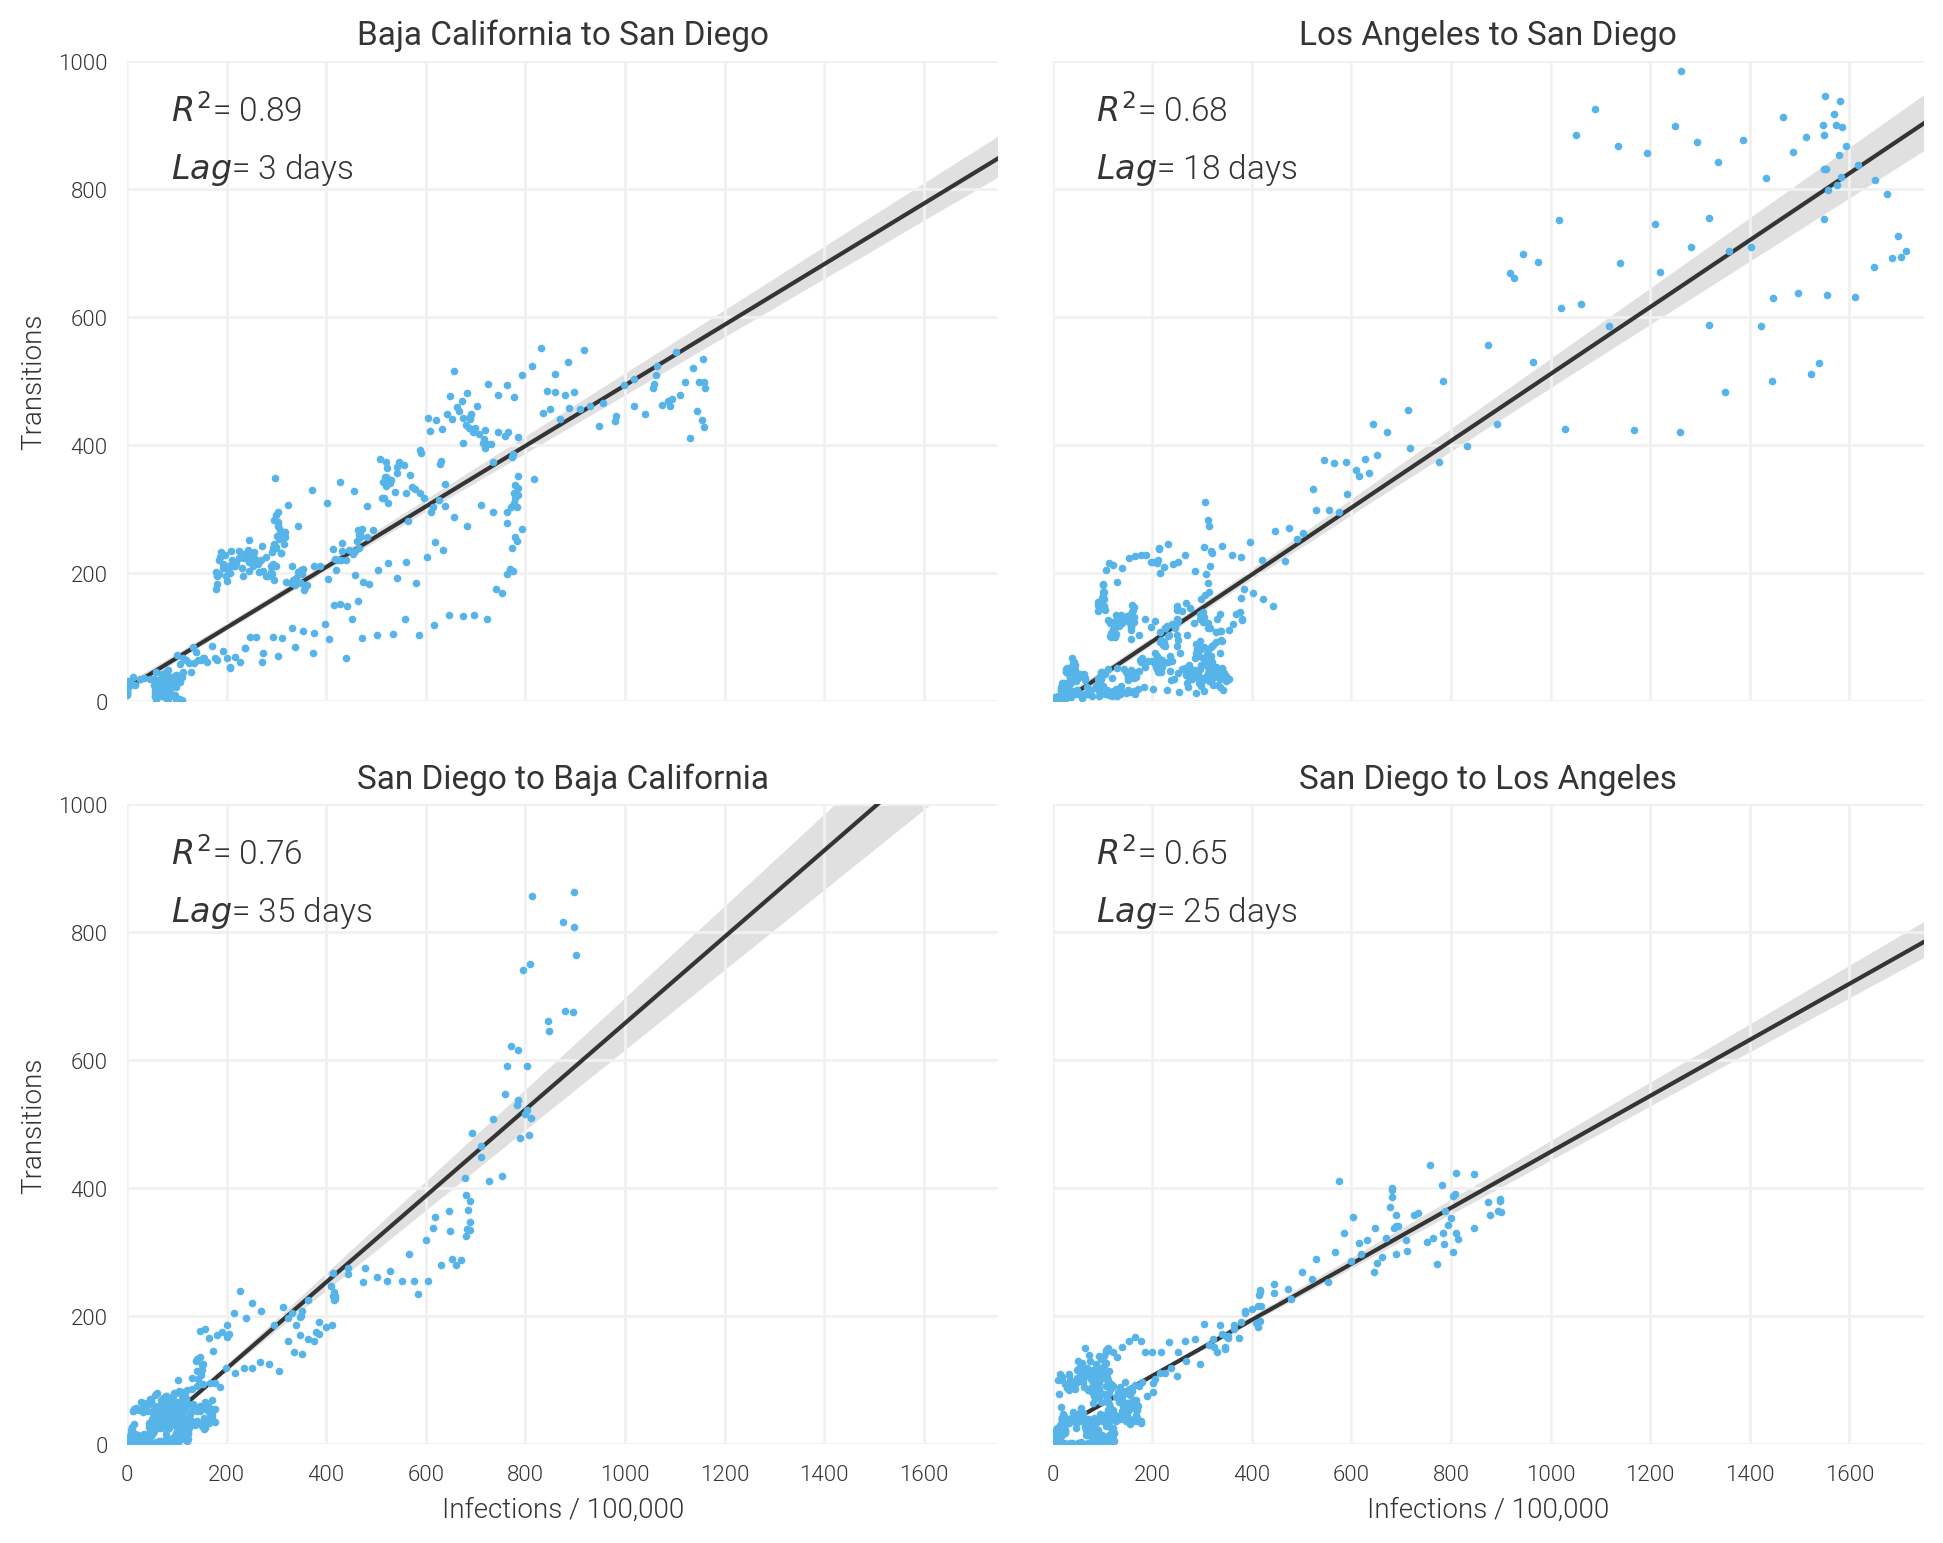

In [138]:
def get_coefficient( x, y ):
    test_x = x.values.reshape(-1, 1)
    test_y = y.values.reshape( -1, 1 )

    #regr = linear_model.LinearRegression()
    #regr.fit( test_x, test_y )

    #Y_pred = regr.predict( test_x )
    result = spearmanr( test_x, test_y, nan_policy="omit" )
    print( result[1] )
    return  result[0] #r2_score( test_y, Y_pred )

def plot_correlation( axis, dependent, independent, shift = 0, color=None, regcolor="black", title=None, xlabel=None, ylabel=None ):

    if isinstance( shift, bool ):
        if shift:
            shift = calculate_lag(dependent, independent )
        else:
            shift = 0

    axis.scatter( x=dependent, y=independent.shift( shift ), color=color, s=3, zorder=10 )
    axis.set_xlim( 0, 1750 )
    axis.set_ylim( 0, 1000 )
    sns.regplot( x=dependent, y=independent.shift( shift ), color=regcolor, scatter=False, line_kws={"zorder" : 5, "linewidth" : 1.5}, ax=axis, truncate=False )

    axis.set_xlabel( xlabel, fontsize=10 )
    axis.set_ylabel( ylabel, fontsize=10 )
    axis.set_title( title, fontsize=12 )

    coeff = get_coefficient(dependent, independent.shift( shift ) )
    axis.text( 0.05, 0.95, f"$R^2$= {coeff:.2f}", transform=axis.transAxes, fontsize=12, ha="left", va="top" )
    axis.text( 0.05, 0.86, f"$Lag$= {shift} days", transform=axis.transAxes, fontsize=12, ha="left", va="top" )
    axis.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1)
    [axis.spines[j].set_visible(False) for j in axis.spines]
    axis.tick_params( axis="x", bottom=False, which="both", labelbottom=True, labelsize=8 )
    axis.tick_params( axis="y", left=False, which="both", labelsize=8 )

    axis.label_outer()

def calculate_lag( dependent, independent ):
    corr = correlate(dependent, independent )
    lags = correlation_lags( len( dependent ), len( independent ) )
    return lags[np.argmax( corr )]

def get_comparison(mj, m, start, end ):
    return_df = mj.merge( m, left_on=["date", "startLocation"], right_on=["date", "location"], how="left" )
    return_df = return_df.loc[(return_df["endLocation"]==end)&(return_df["startLocation"].isin([start]))]
    return_df = return_df[~return_df["cases"].isna()]
    return return_df


fig, ax = plt.subplots( dpi=200, figsize=(10,8), ncols=2, nrows=2, sharex=True, sharey=True )
plot_df = get_comparison(jumps, infections, "Baja California", "San Diego" ).dropna()
shift_days = calculate_lag( plot_df["estimated_infections"], plot_df["jumps"] )
plot_correlation( ax[0][0], plot_df["estimated_infections"]*100000, plot_df["jumps"], shift=True, color="#56B4E9", regcolor=COLOR, title="Baja California to San Diego", xlabel="Infections / 100,000", ylabel="Transitions" )

plot_df = get_comparison(jumps, infections, "Los Angeles", "San Diego" ).dropna()
shift_days = calculate_lag( plot_df["estimated_infections"], plot_df["jumps"] )
plot_correlation( ax[0][1], plot_df["estimated_infections"]*100000, plot_df["jumps"], shift=True, color="#56B4E9", regcolor=COLOR, title="Los Angeles to San Diego", xlabel="Infections / 100,000", ylabel="Transitions" )

plot_df = get_comparison(jumps, infections, "San Diego", "Baja California" ).dropna()
shift_days = calculate_lag( plot_df["estimated_infections"], plot_df["jumps"] )
plot_correlation( ax[1][0], plot_df["estimated_infections"]*100000, plot_df["jumps"], shift=True, color="#56B4E9", regcolor=COLOR, title="San Diego to Baja California", xlabel="Infections / 100,000", ylabel="Transitions" )

plot_df = get_comparison(jumps, infections, "San Diego", "Los Angeles" ).dropna()
shift_days = calculate_lag( plot_df["estimated_infections"], plot_df["jumps"] )
plot_correlation( ax[1][1], plot_df["estimated_infections"]*100000, plot_df["jumps"], shift=True, color="#56B4E9", regcolor=COLOR, title="San Diego to Los Angeles", xlabel="Infections / 100,000", ylabel="Transitions" )
plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_transitions-per-infection.pdf" )
plt.show()

We calculate whether the slope of the correlation is significantly different between the two directions of each location pair. A greater slope indicating that a greater number of transitions resulted from less jumps.

In [139]:
def get_model_results( locA, locB ):
    df = get_comparison(jumps, infections, locA, locB )
    shift_days = calculate_lag( df["jumps"], df["estimated_infections"] )
    df["estimated_infections"] = df["estimated_infections"].shift( shift_days )*100000
    df = df.dropna()
    df["const"] = 1
    model = sm.OLS(df["jumps"], df[["estimated_infections", "const"]])
    return model.fit()

def welchs_dof( std1, std2, size1, size2 ):
    A = np.power( std1, 2 ) / size1
    B = np.power( std2, 2 ) / size2
    df = np.power( A + B, 2 ) / (np.power(A, 2) / ( size1 - 1 ) + np.power( B, 2 ) / ( size2 - 1 ) )
    return df

def compare_slopes( ols1, ols2 ):
    mean1 = ols1.params["estimated_infections"]
    mean2 = ols2.params["estimated_infections"]
    std1 = ols1.bse["estimated_infections"]
    std2 = ols2.bse["estimated_infections"]
    size1 = ols1.nobs
    size2 = ols2.nobs

    value = (mean1 - mean2) / np.sqrt( np.power( std1 / np.sqrt( size1 ), 2 ) + np.power( std2 / np.sqrt( size2 ), 2 ) )
    dof = welchs_dof( std1, std2, size1, size2 )
    rv = t( dof )

    return value, dof, rv.pdf( value )

for pair in [("San Diego", "Baja California"), ("Los Angeles", "San Diego")]:
    print( f"Comparing {pair[0]} to {pair[1]}" )
    model1 = get_model_results( *pair )
    print( f"Slope of {pair[0]} to {pair[1]}: {model1.params['estimated_infections']:.2f} +- {model1.bse['estimated_infections']:.2f}")
    model2 = get_model_results( *reversed( pair ) )
    print( f"Slope of {pair[1]} to {pair[0]}: {model2.params['estimated_infections']:.2f} +- {model2.bse['estimated_infections']:.2f}")
    result = compare_slopes(model1, model2 )
    if result[2] < 0.05:
        print( f"Slopes are significantly different (P = {result[2]})" )
        if model1.params["estimated_infections"] > model2.params["estimated_infections"]:
            print( f"{pair[0]} to {pair[1]} is greater than reverse." )
        else:
            print( f"{pair[1]} to {pair[2]} is greater than reverse." )
    print()

Comparing San Diego to Baja California
Slope of San Diego to Baja California: 0.67 +- 0.01
Slope of Baja California to San Diego: 0.47 +- 0.01
Slopes are significantly different (P = 0.0)
San Diego to Baja California is greater than reverse.

Comparing Los Angeles to San Diego
Slope of Los Angeles to San Diego: 0.52 +- 0.01
Slope of San Diego to Los Angeles: 0.44 +- 0.01
Slopes are significantly different (P = 0.0)
Los Angeles to San Diego is greater than reverse.



/usr/local/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6315: RuntimeWarning: overflow encountered in power
  / (np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)))
/usr/local/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6315: RuntimeWarning: overflow encountered in power
  / (np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)))


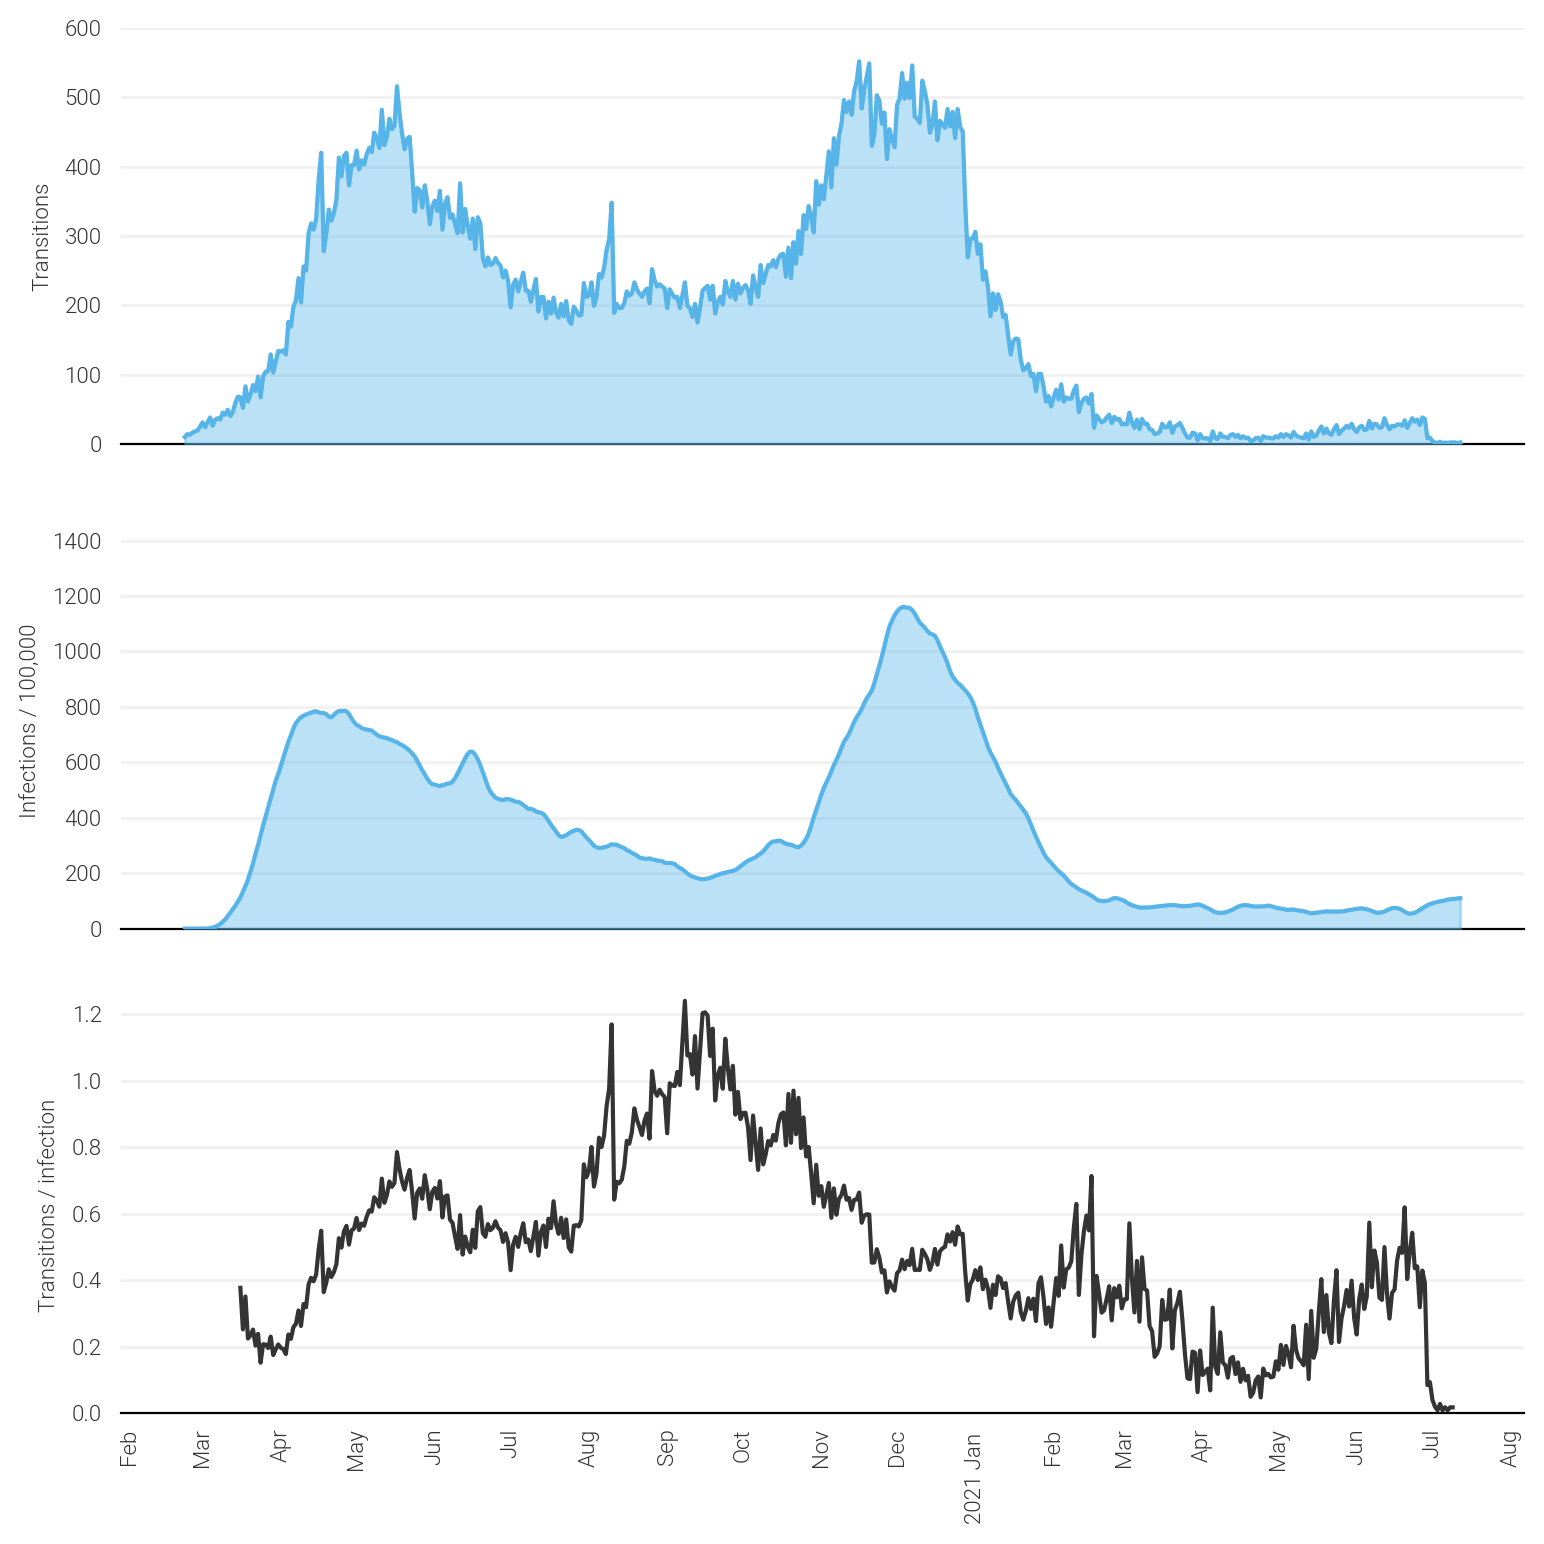

In [20]:
plot_df = jumps.merge( infections, left_on=["date", "startLocation"], right_on=["date", "location"], how="left" )
plot_df = plot_df.loc[(plot_df["endLocation"]=="San Diego")&(plot_df["startLocation"].isin(["Baja California"]))]
plot_df = plot_df[~plot_df["cases"].isna()]
plot_df["estimated_infections"] = plot_df["estimated_infections"] * 100000
lag = calculate_lag( plot_df["jumps"], plot_df["estimated_infections"] )
plot_df["jumps_corrected"] = plot_df["jumps"] / plot_df["estimated_infections"].shift( lag )
plot_df = plot_df.sort_values( "date" )

fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=3, sharex=True )
ax[0].plot( "date", "jumps", data=plot_df, color="#56B4E9", zorder=10, )
ax[0].fill_between( "date", "jumps", 0, data=plot_df, color="#56B4E9", alpha=0.4, zorder=9 )
timeseries_formatting( ax[0], ylabel="Transitions", ylims=(0, 600), ysize=8, xsize=8 )
ax[0].label_outer()
ax[1].plot( "date", "estimated_infections", data=plot_df, color="#56B4E9", zorder=10 )
ax[1].fill_between( "date", "estimated_infections", 0, data=plot_df, color="#56B4E9", alpha=0.4, zorder=9 )
timeseries_formatting( ax[1], ylabel="Infections / 100,000", ylims=(0,1500), ysize=8, xsize=8 )
ax[1].label_outer()

ax[2].plot( "date", "jumps_corrected", data=plot_df.loc[plot_df["date"]>"2020-03-15"], color=COLOR )
timeseries_formatting( ax[2], ylabel="Transitions / infection", ylims=(0,1.25), ysize=8, xsize=8 )
plt.tight_layout()
#plt.savefig( "../figures/bc-sd_cases_infections.pdf" )
plt.show()

-4


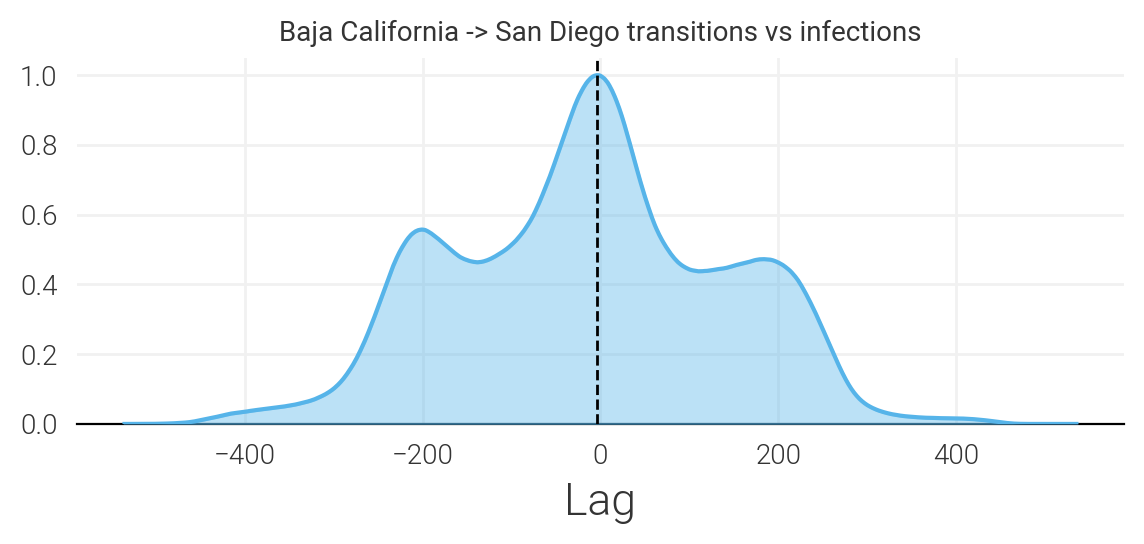

In [49]:
kind = "estimated_infections"
corr = correlate(plot_df["jumps"], plot_df[kind].fillna(0) )
lags = correlation_lags( len(plot_df["jumps"]), len(plot_df[kind]))
corr /= np.max(corr)

print( lags[np.argmax( corr )] )

fig, ax = plt.subplots( dpi=200, figsize=(6,3), )
ax.plot(lags, corr, color="#56B4E9", zorder=10)
plt.fill_between( lags, corr, 0, color="#56B4E9", alpha=0.4, zorder=9 )
ax.axvline( lags[np.argmax( corr )], linestyle="--", linewidth=1, color="black", zorder=11  )
ax.set_xlabel( "Lag" )
ax.set_title( "Baja California -> San Diego transitions vs infections",  fontsize=10 )
[ax.spines[i].set_visible(False) for i in ax.spines if i not in ["bottom"]]
ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, labelsize=10 )
ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=10 )

# Add a simple grid
ax.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1 )
ax.set_ylim( 0 )

plt.tight_layout()
plt.savefig( "../figures/autocorrelation_bc-sd.pdf" )
plt.show()